# EDSA Movie Recommender Systems 2022
© Explore Data Science Academy


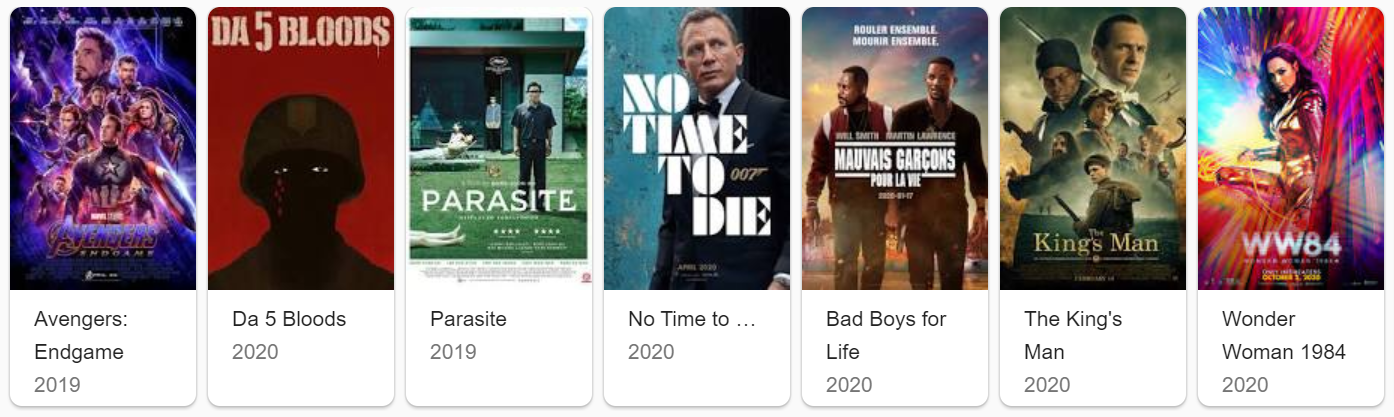

### Honour Code

We {**Team 3**}, confirm - by submitting this document - that the solutions in this notebook are a result of our own work and that we abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

<a id="cont"></a>
## Table of Contents
<a href=#one>1. Overview
    
<a href=#two>2. Evaluation Metric
    
<a href=#three>3. Comet Experiment
    
<a href=#four>4. Importing Libraries
    
<a href=#five>5. Loading Data
    
<a href=#six>6. Exploratory Data Analysis
    
<a href=#seven>7. Recommender System: Collaborative Filtering
    
<a href=#eight>8. Dimensionality Reduction
    
<a href=#nine>9. Recommender System: Content Based Filtering
    
<a href=#ten>10. Conclusion
    
<a href=#eleven>11. Kaggle Submission

<a id="one"></a>
## 1. Overview
<a href=#cont>Back to Table of Contents</a>


In today’s technology driven world, recommender systems are socially and economically critical to ensure that individuals can make optimised choices surrounding the content they engage with on a daily basis. One application where this is especially true is movie recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being personalised recommendations - generating platform affinity for the streaming services which best facilitates their audience's viewing.

#### 1.1 Data Overview
This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

For this Predict, we'll be using a special version of the MovieLens dataset which has enriched with additional data, and resampled for fair evaluation purposes.

#### 1.2 Source
The data for the MovieLens dataset is maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB

#### 1.3 Supplied files
- genome_scores.csv - a score mapping the strength between movies and tag-related properties
- genome_tags.csv - user assigned tags for genome-related scores
- imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file
- links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs
- sample_submission.csv - Sample of the submission format for the hackathon
- tags.csv - User assigned for the movies within the dataset
- test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
- train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data

 <a id="two"></a>
## 2. Evaluation Metric
<a href=#cont>Back to Table of Contents</a>

---
The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process. For our task of generating user movie ratings via recommendation algorithms, the the formula is given by:

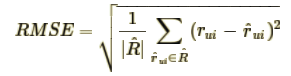 Where 
R
^
 is the total number of recommendations generated for users and movies, with 
r
u
i
 and 
r
^
u
i
 being the true and predicted ratings for user 
u
 watching movie 
i
 respectively.

 <a id="three"></a>
## 3. Comet Experiment
<a href=#cont>Back to Table of Contents</a>

---

In [1]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="mmOpPSheJulnOrFlE3B5KW2e1",
    project_name="recommender-systems",
    workspace="deelianne",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/deelianne/recommender-systems/b44fc0bb7a74407c9966098064f040c1



 <a id="four"></a>
## 4. Importing Libraries
<a href=#cont>Back to Table of Contents</a>

---

In [2]:
# Import required packages
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')
import surprise
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering


from sklearn import metrics
import math


 <a id="five"></a>
## 5. Loading Data
<a href=#cont>Back to Table of Contents</a>

---

In [3]:
#Movies dataframe
movies_df = pd.read_csv('movies.csv')

#Genome_scores dataframe
gs_df = pd.read_csv('genome_scores.csv')

#Genome_tags dataframe
gt_df = pd.read_csv('genome_tags.csv')

#imbd dataframe
imdb_df = pd.read_csv('imdb_data.csv')

#links dataframe
links_df = pd.read_csv('links.csv')

#tags dataframe
tags_df = pd.read_csv('tags.csv')

#train dataframe
train_df = pd.read_csv('train.csv')

#test dataframe 
test_df = pd.read_csv('test.csv')

#sample submission
sample_df = pd.read_csv('sample_submission.csv')

In [5]:
# first five rows of the train dataframe
train_df.head()

userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837

In [7]:
#dropping the timestamp column
train_df = train_df.drop(columns = 'timestamp', axis = 1)
train_df.head()

userId  movieId  rating
0    5163    57669     4.0
1  106343        5     4.5
2  146790     5459     5.0
3  106362    32296     2.0
4    9041      366     3.0

In [8]:
# first five rows of the test dataframe
test_df.head()

userId  movieId
0       1     2011
1       1     4144
2       1     5767
3       1     6711
4       1     7318

 <a id="six"></a>
## 6. Exploratory Data Analysis
<a href=#cont>Back to Table of Contents</a>

---

**Exploratory data analysis (EDA)** is used to analyze and investigate data sets and summarize their main characteristics, often employing data visualization methods. It helps determine how best to manipulate data sources to get the answers you need, making it easier to discover patterns, spot anomalies, test a hypothesis, or check assumptions.

EDA is primarily  provides a better understanding of data set variables and the relationships between them. It can also help determine if the statistical techniques you are considering for data analysis are appropriate. 
The main purpose of EDA is to help look at data before making any assumptions. It can help identify obvious errors, as well as better understand patterns within the data, detect outliers or anomalous events, find interesting relations among the variables. [Source](https://www.ibm.com/cloud/learn/exploratory-data-analysis).

We took a deep dive into the statistical analysis of the data, checked its distribution, shape, null values.
Here are some of the analysis we did:

#### 6.1)Ratings distribution

#### 6.2)Ratings distribution by movie

#### 6.3)Ratings distriution by user


In [9]:
# access the data types, and number of observations and features present in the train dataframe
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 228.9 MB


In [10]:
train_df.shape

(10000038, 3)

In [11]:
# check for missing values
train_df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

The code above checks for the presence of null values within columns and sums them together. All columns resulted to sums of zero(0), Hence signifying the absence of null values.This check for missing values is important as to determine whether statistical steps like filling the empty rows with either the mean, mode, or median as the case may be required.

In [12]:
# Descriptive statistics of the train data
train_df.describe().T 

count          mean           std  min      25%      50%  \
userId   10000038.0  81199.088145  46793.586156  1.0  40510.0  80914.0   
movieId  10000038.0  21389.111613  39195.781053  1.0   1197.0   2947.0   
rating   10000038.0      3.533395      1.061124  0.5      3.0      3.5   

              75%       max  
userId   121579.0  162541.0  
movieId    8630.0  209171.0  
rating        4.0       5.0

In [13]:
#checking for unique values in the train dataset
train_df.userId.nunique()
train_df.movieId.nunique()

48213

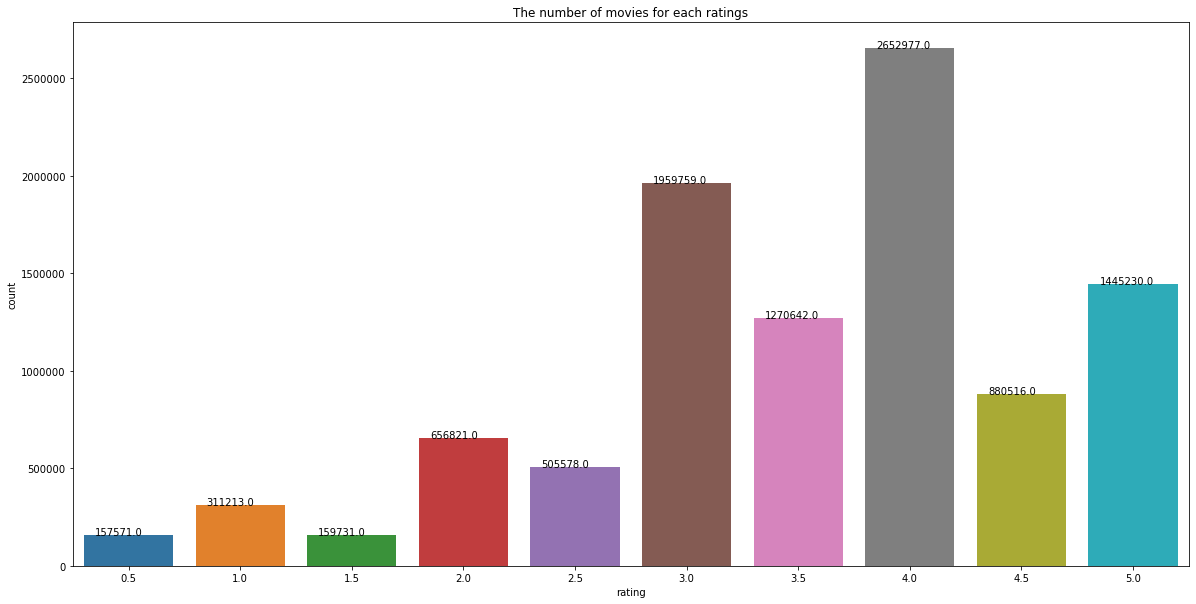

Average rating in dataset: 3.5333951730983424


In [14]:
# Plotting the graph
fig, ax = plt.subplots(figsize=(20, 10)) # Initialize the plot with set figure size

sns.countplot(ax=ax, x='rating', data=train_df) # Create a countplot to visualise the number of movies per category
ax.set_title("The number of movies for each ratings")
plt.ticklabel_format(style='plain', axis='y', useOffset=False) # Set the tick labels to appear in non-scientific form

# Make the counts appear on the different
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
    
# Show the countplot
plt.show()
print (f'Average rating in dataset: {np.mean(train_df["rating"])}')

The figure above shows the distribution of movie ratings. Most viewers rated the movie at **4.0** and the **0.5** and **1.5** were the ratings with the least count.

### 6.1) Ratings Distribution

In [15]:
#movie ratings distribution as a percentage
data = train_df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / train_df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} movie-ratings'.format(train_df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can see that over 26% of all ratings in the data are 4, and very few ratings are 0.5, 1.0, 1.5, 2.5 and 3.0. Low rating movies mean they are generally really bad and not highly recommended by users.

In [16]:
# number of times each rating appears
train_df.rating.value_counts()

4.0    2652977
3.0    1959759
5.0    1445230
3.5    1270642
4.5     880516
2.0     656821
2.5     505578
1.0     311213
1.5     159731
0.5     157571
Name: rating, dtype: int64

The above count shows the exact number ratings by users.

### 6.2) Ratings Distribution By Movie

In [19]:
# Number of ratings per movie
data = train_df.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per movie (Clipped at 100)',
                   xaxis = dict(title = 'Number of Ratings Per movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [20]:
# check the highest number of rating for a movie
train_df.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending = False)[:100]

movieId  rating
314       318   32831
351       356   32383
292       296   31697
585       593   29444
2479     2571   29014
...       ...     ...
109       111   11600
5307     5418   11577
903       924   11562
579       587   11468
762       778   11427

[100 rows x 2 columns]

We can see that the highest rating for a particular movie is **32831**, coming from a movie with movieId as **314**.

In [21]:
#check the lowest number of rating for a movie
train_df.groupby('movieId')['rating'].count().reset_index().sort_values('rating')[:100]

movieId  rating
48212   209171       1
31518   152743       1
31516   152737       1
31515   152733       1
31514   152731       1
...        ...     ...
31427   152397       1
31415   152350       1
31412   152344       1
31410   152338       1
31409   152336       1

[100 rows x 2 columns]

We can see how poorly rated some movies were. From the above, several movies were rated just once(1).

### 6.3) Ratings Distribution By User

In [22]:
# Number of ratings per user
data = train_df.groupby('userId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [23]:
#check the user with the highest rating
train_df.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:100]


userId  rating
72314    72315   12952
80973    80974    3680
137292  137293    3588
33843    33844    3208
20054    20055    3050
...        ...     ...
115899  115900    1318
72355    72356    1305
106506  106507    1302
144713  144714    1299
158108  158109    1295

[100 rows x 2 columns]

The most productive user with a **userId** of **72315** gave ratings of movies for about **12952** times.

In [24]:
#check the user with the lowest rating
train_df.groupby('userId')['rating'].count().reset_index().sort_values('rating')[:100]


userId  rating
105713  105714       1
53639    53640       1
127097  127098       1
121070  121071       1
55361    55362       1
...        ...     ...
14907    14908       3
50543    50544       3
43623    43624       3
80435    80436       3
19199    19200       3

[100 rows x 2 columns]

from here, we can see that users rarely rated movies, with several users rating movies just once(1). This shows the lack of productivity in rating movies.

 <a id="seven"></a>
## 7. Recommender Systems: Collaborative Filtering
<a href=#cont>Back to Table of Contents</a>

---

### 7.1) Surprise
Surprise is an open-source Python library that makes it easy for developers to build recommender systems with explicit rating data.

**Create a Surprise Dataset**

In order to train recommender systems with Surprise, we need to create a Dataset object. A Surprise Dataset object is a dataset that contains the following fields in this order:
The user IDs
The item IDs (in this case the IDs for each movie)
The corresponding rating (usually on a scale such as 1–5)

**Training and Cross-Validating a Simple SVD Model**

We can train and cross-validate a model that performs SVD (singular value decomposition) in order to build a recommendation system in just a few lines of code. SVD is a popular matrix factorization algorithm that can be used for recommender systems.
Recommender systems that use matrix factorization generally follow a pattern where a matrix of ratings is factored into a product of matrices representing latent factors for the items (in this case movies) and the users.

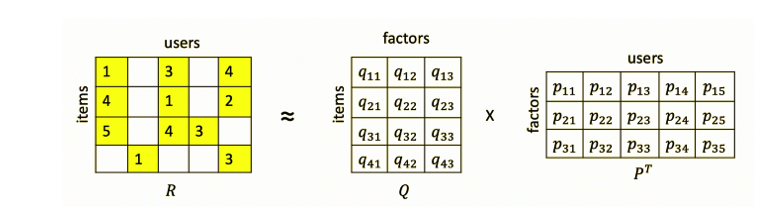

Considering the figure above, notice how the rating matrix, R, has missing values in some places. The matrix factorization algorithm uses a procedure such as gradient descent to minimize the error when predicting existing ratings using the matrix factors. Thus, an algorithm like SVD builds a recommendation system by allowing us to “fill in the gaps” in the rating matrix, predicting the ratings that each user would assign to each item in the dataset.
Starting with an input matrix A, SVD actually factorizes the original matrix into three matrices as demonstrated in the equation below.

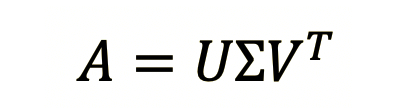

We can map these new matrices to the rating matrix R and the item and user factors Q and P as follows:
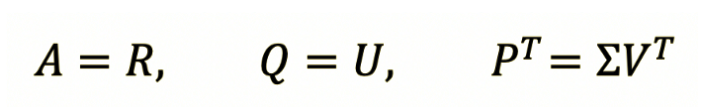

In the case of our movie recommendation system, the SVD algorithm will represent the rating matrix as a product of matrices representing the movie factors and user factors respectively.

In [74]:
from surprise import Reader, Dataset

In [27]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)

In [28]:
trainset = data.build_full_trainset()

svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


#### Generating Rating Predictions
Now that we have a trained SVD model, we can use it to predict the rating a user would assign to a movie given an ID for the user(userId) and an ID for the movie(movieId). The code above demonstrates how to do this...

<a id="eight"></a>
## 8. Recommender Systems: Content- Based Filtering
<a href=#cont>Back to Table of Contents</a>

---

Content-Based recommender system tries to guess the features or behavior of a user given the item’s features, he/she reacts positively to. Once, we know the likings of the user we can embed him/her in an embedding space using the feature vector generated and recommend him/her according to his/her choice. During recommendation, the similarity metrics are calculated from the item’s feature vectors and the user’s preferred feature vectors from his/her previous records. Then, the top few are recommended. Content-based filtering does not require other users' data during recommendations to one user.



In [33]:
#train dataframe
train_df = pd.read_csv('train.csv')

In [34]:
#Checking for users average rating
train_df1 = pd.DataFrame(train_df.groupby('userId')['rating'].agg('mean').reset_index())
train_df2 = pd.DataFrame(train_df.groupby('userId')['rating'].count().reset_index())

In [35]:
#Merge train_df1 and train_df2
train_df1 = train_df1.merge(train_df2,on='userId',how = 'left')

In [36]:
# Rename the columns respectively
train_df1.rename(columns={'rating_x':'avg_rating','rating_y':'number_of_movies'},inplace = True)

In [37]:
# Sort the data in descending of the number of movies the user has rated
train_df1 = train_df1.sort_values('number_of_movies', ascending = False)
train_df1.head()

userId  avg_rating  number_of_movies
72314    72315    3.092380             12952
80973    80974    3.277582              3680
137292  137293    3.192168              3588
33843    33844    2.583853              3208
20054    20055    3.179016              3050

In [38]:
train_movies = train_df.merge(movies_df,on = 'movieId') # Merges the movie and train datasets
train_movies.drop(columns=['timestamp'],inplace=True) # Dropping the timestamp column
train_movies.head(10) # Shows the first 10 observations

userId  movieId  rating             title                       genres
0    5163    57669     4.0  In Bruges (2008)  Comedy|Crime|Drama|Thriller
1   87388    57669     3.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
2  137050    57669     4.0  In Bruges (2008)  Comedy|Crime|Drama|Thriller
3  120490    57669     4.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
4   50616    57669     4.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
5   99887    57669     0.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
6  120194    57669     4.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
7     847    57669     3.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
8   47201    57669     4.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
9   94499    57669     4.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller

In [39]:
# Create a new dataframe from the train_movies dataframe to get the average rating  
train_2 = train_movies.copy()

# Drop any duplicated information 
train_2.drop_duplicates(['title','genres'],inplace = True)

# Get the  avarage rating for each movie in the data 
total_ratings = train_movies.groupby(['movieId','genres']).mean()['rating'].reset_index()

# Merge the the train2 and the total_ratings to create a new data 
train_2 = train_2.merge(total_ratings, on = 'movieId')

train_2.drop(columns=['userId','rating_x','genres_y'],inplace=True) # Delete the duplicated columns

train_2.rename(columns={'genres_x':'genres','rating_y':'rating'},inplace=True) # Rename the columns

# Show the  first 5 observations
train_2.head()

movieId                                              title  \
0    57669                                   In Bruges (2008)   
1        5                 Father of the Bride Part II (1995)   
2     5459  Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...   
3    32296     Miss Congeniality 2: Armed and Fabulous (2005)   
4      366  Wes Craven's New Nightmare (Nightmare on Elm S...   

                          genres    rating  
0    Comedy|Crime|Drama|Thriller  3.889842  
1                         Comedy  3.059165  
2           Action|Comedy|Sci-Fi  3.004276  
3         Adventure|Comedy|Crime  2.535714  
4  Drama|Horror|Mystery|Thriller  2.972609

In [40]:
train_3 = train_2.copy() # Make a copy of the train_2 dataset
# Create a user dataset to check how many time it has been voted for
user_rated = pd.DataFrame(train_df['movieId'].value_counts().reset_index()) # Create a user dataframe using groupby function

user_rated.rename(columns = {'index':'movieId','movieId':'voted'},inplace = True) # Rename the columns 

train_3 = train_3.merge(user_rated, on ='movieId') # Combine the train3 dataset with the User_rated data

# Filter the data 
train_3 = train_3[train_3['voted'] > 10] # Find the movies which have the us voted for more than 50 

train_3 = train_3.sort_values('rating',ascending=False) # Sort the values by the rating feature

train_3.head() # Show the first 5 observations 

movieId                   title              genres    rating  voted
18499   174551        Obsession (1965)              Comedy  4.772727     11
5148    171011  Planet Earth II (2016)         Documentary  4.517084    439
1152    171705        Den radio (2001)  (no genres listed)  4.500000     13
2660    159817     Planet Earth (2006)         Documentary  4.473294    674
9966    171495                  Cosmos  (no genres listed)  4.456897    116

In [41]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies_df[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

movieId     genres
0        1  Adventure
1        1  Animation
2        1   Children
3        1     Comedy
4        1    Fantasy

### Movie Genre Analysis

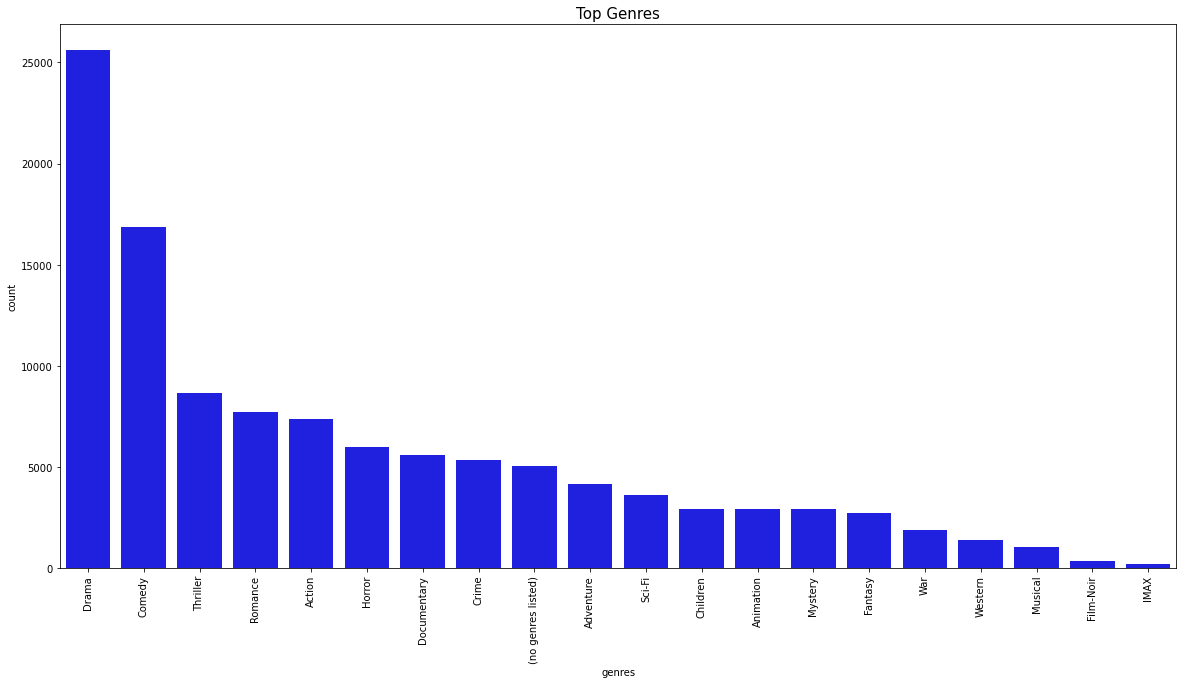

In [42]:
# Ploting top genres in the Dataset
plt.figure(figsize=(20, 10))
gen = movies_genres['genres'].explode()
ax=sns.countplot(x=gen, order=gen.value_counts().index[:30],color='blue')
ax.set_title('Top Genres', fontsize=15)
plt.xticks(rotation =90)
plt.style.use("dark_background")
plt.show()

In [43]:
def data_preprocessing(subset_size):
    """Prepare data for use within Content filtering algorithm.

    Parameters
    ----------
    subset_size : int
        Number of movies to use within the algorithm.

    Returns
    -------
    Pandas Dataframe
        Subset of movies selected for content-based filtering.

    """
    movies = movies_df.copy()
    # Split the genres feature so that each genres will be in a list format 
    movies['genres'] = movies.genres.str.split('|')

    #Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
    moviesWithGenres_df = movies.copy()

    #For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
    for index, row in movies.iterrows():
        for genre in row['genres']:
            moviesWithGenres_df.at[index, genre] = 1
    #Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
    moviesWithGenres_df = moviesWithGenres_df.fillna(0)
    moviesWithGenres_df.drop(['genres'],axis =1, inplace = True)
    # Slice the data
    movie_subset = moviesWithGenres_df[:subset_size]

    return movie_subset

In [44]:
def content_model(movie_list,top_n=10):
    """Performs Content filtering based upon a list of movies supplied
       by the app user.

    Parameters
    ----------
    movie_list : list (str)
        Favorite movies chosen by the app user.
    top_n : type
        Number of top recommendations to return to the user.

    Returns
    -------
    list (str)
        Titles of the top-n movie recommendations to the user.

    """
    # Initializing the empty list of recommended movies
    recommended_movies = []
    # Preprocess the data 
    data = data_preprocessing(27000)

    # Create a new DataFrame
    data2 = data.copy()

    # Change the index of the DataFrame
    data2 = data2.set_index('title')

    # Delete the columns the unneccesary columns 
    data.drop(['title'],axis = 1,inplace=True)
    
    # Generating the count matrix for each genres
    data = data.set_index('movieId')

    # Instantiating the model and fitting the model to the count matrix
    nn = NearestNeighbors(algorithm='brute',metric='cosine',n_neighbors=10)
    nn.fit(data)

    # Create an Empty list for the movieids
    movieids = []

    # Getting the movieids
    ind1 = data2.loc[movie_list[0],'movieId']
    ind2 = data2.loc[movie_list[1],'movieId']
    ind3 = data2.loc[movie_list[2],'movieId']

    # Adding the movieids to the list
    movieids.extend([ind1,ind2,ind3])
    # Setting a list of indexes
    index_list = []

    # Getting the suggestions in form of indexes
    for i in range(len(movieids)):
        distances,suggestions=nn.kneighbors(data.loc[movieids[i],:].values.reshape(1,-1),n_neighbors=15)

        for j in range(15):
            index_list.append(suggestions[0,j])

    # Creating an empty list to store the movie ids 
    movieids2 = []
    
    # Create a for loop get the titles of the movies
    for i in range(len(index_list)):
        id = data.index.values[index_list[i]]
        movieids2.append(id)

    # Create a list to store all the titles
    title_list = []

    # Create a new dataframe to get the titles of the movies and change the index to movieId 
    data3 = data_preprocessing(27000)
    data3 = data3.set_index('movieId')

    for i in range(len(movieids2)):
        title = data3.loc[movieids2[i],'title']
        if(title not in movie_list):
            title_list.append(title)

    # recommended movies 
    recommended_movies.extend(random.sample(title_list,k = top_n))
    return recommended_movies

In [48]:
from sklearn.neighbors import  NearestNeighbors

# Packages for Randomisation
import random

In [49]:
# Declare a movie list 
movielist = ["Shrek the Third (2007)","Jumanji (1995)","Grumpier Old Men (1995)"]

# Run the recommendation
recommendation = content_model(movielist,10)

print(recommendation)

['The Magic Crystal (2011)', 'Escape to Witch Mountain (1975)', 'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)', "Slugger's Wife, The (1985)", 'Chef in Love, A (Shekvarebuli kulinaris ataserti retsepti) (1997)', 'Merrily We Live (1938)', 'Toy Story Toons: Hawaiian Vacation (2011)', 'Santa Claus: The Movie (1985)', 'Aladdin (1992)', 'Week-End With Father (1951)']


## Dimensionality Reduction


A widely encountered problem in machine learning is that of dimensionality. We typically refer to the size or shape of a dataset as an  𝑛
n
  x  𝑝
p
  matrix, where each row from 1 to  𝑛
n
  represents an observation, or data point, and each column from 1 to  𝑝
p
  represents a variable, or feature. With each additional feature, the dimensionality of a dataset increases by 1.
The problems with increasing or high levels of dimensionality are as follows:
More storage space required for the data;
More computation time required to work with the data; and
More features mean more chance of feature correlation, and hence feature redundancy.
The latter point is the basis on which principal component analysis is carried out. A feature that is highly correlated with another increases when the other increases (positive correlation), or decreases when the other increases (negative correlation). This is helpful, because if multiple features tend to behave in a corresponding manner in the dataset, they can often be replaced by some smaller quantity of representative feature(s). This helps to lower the feature space within which the data reside, reducing computation time as well as storage capacity requirements.
The goal of dimensionality reduction is to reduce the number of features in a dataset while minimising the amount of data loss. There are three primary methods by which this can be done:

**i)Principal Component Analysis (PCA)**

**ii)Linear Discriminant Analysis (LDA)**

**iii)Generalised Discriminant Analysis (GDA)**

In this notebook we will focus on PCA.
To reduce the dimensionality of the data set, and avoid running into “memory error”, we will filter out rarely rated movies and rarely rating users.

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [54]:
# Scaling the movies_df
# declare the features to be all columns from our movies_df
features = [col for col in train_df.columns]

# create scaler object
scaler = StandardScaler()

# define scaled data frame variable
scaled_df = pd.read_csv('train.csv')
scaled_df[features] = preprocessing.scale(scaled_df[features])

In [56]:
from sklearn.decomposition import PCA

Text(0, 0.5, 'Cumulative explained variance')

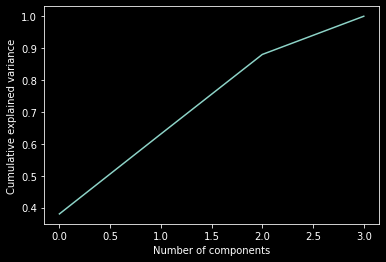

In [57]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(scaled_df[features])

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp)



# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [58]:
pca_85 = PCA(.85)
pca_85.fit_transform(scaled_df[features])
print(round(pca_85.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_85.n_components_,
      "components.")

88.0 % of variance explained by 3 components.


In [59]:
pca.explained_variance_ratio_[:3]

array([0.3802045 , 0.25060905, 0.24947369])

In [60]:
#sns.scatterplot(x = pca_df[:,0], y = pca_df[:,1], hue = label, palette = sns.hls_palette(10), legend = 'full');

In [61]:
# exclude non-features from data
reg_data = scaled_df[features]

# set aside response variable (Unscaled!)
reg_response = train_df["rating"]

# drop response variable
reg_data = reg_data.drop(['rating'], 1)

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(reg_data, reg_response, test_size=0.2)

In [65]:
# create PCA object with n_components set to 2
pca_reg = PCA(n_components=2)

# fit the PCA model to our data and apply the dimensionality reduction 
X_train = pca_reg.fit_transform(X_train)

# confirm the number of components
pca_reg.n_components_

2

In [66]:
pca_reg.explained_variance_ratio_.sum()

0.840230197780438

In [67]:
#label = reg_data["label"]
#label.value_counts()

In [68]:
#from sklearn.manifold import TSNE
#tsne = TSNE(n_components = 2, random_state=0)
#tsne_res = tsne.fit_transform(X_train)

#sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = label, palette = sns.hls_palette(10), legend = 'full');

In [69]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate


# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin('ml-100k')

# We'll use the SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results for smaller movie dataset
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9359  0.9377  0.9396  0.9310  0.9375  0.9363  0.0029  
MAE (testset)     0.7368  0.7402  0.7399  0.7349  0.7371  0.7378  0.0020  
Fit time          5.39    5.26    5.23    5.25    5.23    5.27    0.06    
Test time         0.56    0.13    0.13    0.13    0.22    0.23    0.17    


{'test_rmse': array([0.93592632, 0.9376806 , 0.93955682, 0.93101777, 0.93749477]),
 'test_mae': array([0.73683955, 0.7402141 , 0.73985172, 0.73491077, 0.73709237]),
 'fit_time': (5.3932411670684814,
  5.256581783294678,
  5.233259916305542,
  5.249475002288818,
  5.231933355331421),
 'test_time': (0.5582702159881592,
  0.13033604621887207,
  0.13247013092041016,
  0.13021421432495117,
  0.2219858169555664)}

In [77]:
train_df4 = pd.read_csv('train.csv')

In [78]:
train_df4.head()

userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837

In [72]:
import csv

In [79]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

#our training data
df = pd.DataFrame(train_df4)
del df['timestamp']


# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [80]:
#packages we need
from surprise import accuracy
from surprise.model_selection import train_test_split

#allows us to train on the whole dataset
trainset = data.build_full_trainset()

#SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)

In [81]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the SVD algorithm.
algo2 = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo2.fit(trainset)
predictions = algo2.test(testset)

# Compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8387


0.8387161754485766

In [82]:
test_df.head()

userId  movieId
0       1     2011
1       1     4144
2       1     5767
3       1     6711
4       1     7318

In [83]:
test_df.loc[:, 'rating'] = 0
test_df.head()

userId  movieId  rating
0       1     2011       0
1       1     4144       0
2       1     5767       0
3       1     6711       0
4       1     7318       0

In [84]:
#using load_from_df surprise function to load dataset for predictions
test_processed = Dataset.load_from_df(test_df[['userId','movieId','rating']], reader)

#Train test split, test size will be equal to 1.
NA, test = train_test_split(test_processed, test_size=1.0, shuffle = False, random_state = 42)

#Prediction 
predictions = algo.test(test)

In [85]:
#saving the predictions as a list to add as a column for our Kaggle submission
ratings = [i.est for i in predictions]
ratings

[3.094502996259478,
 4.1416751569021,
 3.7391559615808605,
 4.3993647684087245,
 3.1747940035337012,
 4.039762535742452,
 4.0407103772888355,
 3.3976774612764684,
 3.5963445763733155,
 3.3340329621379845,
 3.202206406000627,
 2.803760157315231,
 3.911932391100634,
 4.664934870121451,
 4.128826942662245,
 4.072056750873911,
 3.692802340556578,
 2.737670369202421,
 3.3354003512782606,
 3.278515660202157,
 3.7900011092920884,
 3.5007758700661396,
 2.9254434541107086,
 3.258117616456304,
 3.5898562102764506,
 3.6578811185754447,
 3.7781415125342592,
 3.2284865087178716,
 3.3613746403398044,
 3.5771579040441743,
 3.8492415242755706,
 3.24447342261563,
 3.4397870742111434,
 2.8440577628824895,
 2.805664442733934,
 3.422288398299826,
 3.410157186995325,
 3.6658050013825885,
 5,
 3.1956651322173006,
 3.87633060617516,
 3.6437722043161878,
 4.253940053168784,
 3.5686300618006035,
 4.619087446691765,
 3.599810097997177,
 3.8879182569939283,
 4.5344306538338595,
 3.855503487625683,
 4.30305062850

In [86]:
test_df['Id'] = test_df['userId'].astype(str)  + '_'+ test_df['movieId'].astype(str) 

In [87]:
test_df

userId  movieId  rating           Id
0             1     2011       0       1_2011
1             1     4144       0       1_4144
2             1     5767       0       1_5767
3             1     6711       0       1_6711
4             1     7318       0       1_7318
...         ...      ...     ...          ...
5000014  162541     4079       0  162541_4079
5000015  162541     4467       0  162541_4467
5000016  162541     4980       0  162541_4980
5000017  162541     5689       0  162541_5689
5000018  162541     7153       0  162541_7153

[5000019 rows x 4 columns]

In [88]:
#change rating column
test_df['rating'] = ratings
del test_df['userId']
del test_df['movieId']

In [89]:
test_df

rating           Id
0        3.094503       1_2011
1        4.141675       1_4144
2        3.739156       1_5767
3        4.399365       1_6711
4        3.174794       1_7318
...           ...          ...
5000014  3.178829  162541_4079
5000015  3.969631  162541_4467
5000016  2.630409  162541_4980
5000017  2.807627  162541_5689
5000018  5.000000  162541_7153

[5000019 rows x 2 columns]

In [90]:
test_df['R'] = test_df['rating']
del test_df['rating']

In [91]:
test_df['rating'] = test_df['R']

In [92]:
del test_df['R']

In [93]:
test_df

Id    rating
0             1_2011  3.094503
1             1_4144  4.141675
2             1_5767  3.739156
3             1_6711  4.399365
4             1_7318  3.174794
...              ...       ...
5000014  162541_4079  3.178829
5000015  162541_4467  3.969631
5000016  162541_4980  2.630409
5000017  162541_5689  2.807627
5000018  162541_7153  5.000000

[5000019 rows x 2 columns]

In [ ]:
#test_df.to_csv('submission.csv', index = False)

In [94]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/deelianne/recommender-systems/b44fc0bb7a74407c9966098064f040c1
COMET INFO:   Parameters:
COMET INFO:     algorithm     : brute
COMET INFO:     leaf_size     : 30
COMET INFO:     metric        : cosine
COMET INFO:     metric_params : 1
COMET INFO:     n_jobs        : 1
COMET INFO:     n_neighbors   : 10
COMET INFO:     p             : 2
COMET INFO:     radius        : 1.0
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, params, and assets to Comet before program termin